In [1]:
from vpython import * 
from pypylon import pylon
import cv2 as cv
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.ticker import FormatStrFormatter
import time
from openpyxl import Workbook
import xlwt
from datetime import datetime
import random
from itertools import count
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation
from drawnow import drawnow
from bokeh.plotting import curdoc, figure
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import numpy.ma as ma
import math
import time
import circle_fit as cf
import matplotlib.colors as mcolors
import config_constants as cc
%matplotlib inline 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,original_pos_xy,Final_pos_xy,max_xy,min_xy,Radius_x,Radius_y,Area
0,"(9.30325, 5.86075)","([9.31175], [5.852250000000001])","(9.328750000000001, 5.877750000000001)","(9.28625, 5.84375)",0.02125,0.017,0.13345


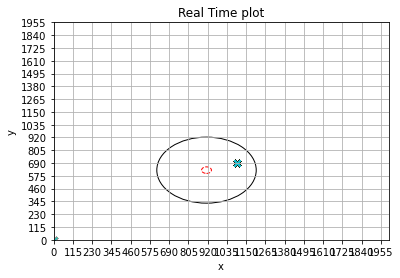

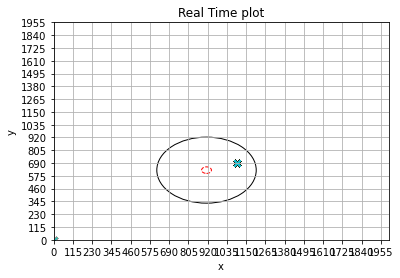

In [2]:
def read_circle():
    
    conversion = cc.conversion

    # conecting to the first available camera
    camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
    camera.Open()
    #camera.Width = 4112
    #camera.Height = 2172
    camera.CenterX.SetValue(True)
    camera.Width.SetValue(1800)
    camera.CenterY.SetValue(True)
    camera.Height.SetValue(1800)
    camera.Close()
    # Grabing Continusely (video) with minimal delay
    camera.StartGrabbing(pylon.GrabStrategy_LatestImageOnly)
    converter = pylon.ImageFormatConverter()

    # converting to opencv bgr format
    converter.OutputPixelFormat = pylon.PixelType_BGR8packed
    converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned

    # def for circle shape detection
    prevCircle = None
    dist = lambda x1,y1,x2,y2: (x1-x2)**2+(y1-y2)**2
    x = np.empty(1)
    y = np.empty(1)
    #livegraph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    circle_x = cc.circle['circle_x'] 
    circle_y = cc.circle['circle_y']    
    circle_r = cc.circle['circle_r']
    circle1 = plt.Circle( (circle_x  /conversion, circle_y/conversion ), circle_r/conversion , fill = False )
    circle2 = plt.Circle( (circle_x  /conversion, circle_y/conversion ), 0.25/conversion , fill = False, color = 'r', linestyle = '--' )
    ax.add_artist( circle1 )
    ax.add_artist( circle2 )
    #fig, (ax1, ax2) = plt.subplots(2)
    ax.set_xlim(500,2000)
    ax.set_ylim(0,1000)
    ax.set_xticks(np.arange(0, 2000, 115))
    ax.set_yticks(np.arange(0, 2000, 115))
    plt.grid()
    #def for background change to black and white
    object_detector = cv.createBackgroundSubtractorMOG2(history=100, varThreshold=70)

    #def for set time counter 
    t = 0
    tmax = 60
    dt = .5
    #display 
    scene1 = canvas()
    #display(fig)
    #measure the time
    st = time.time()
    #Camera grabbing while loop and set count time 
    while camera.IsGrabbing() and t < tmax:
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data
            image = converter.Convert(grabResult)
            img = image.GetArray()
        if not grabResult.GrabSucceeded: break

    #Frame color control 
        GrayFrame = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        blurFrame = cv.GaussianBlur(GrayFrame, (17,17),0)
        thresh = cv.threshold(blurFrame, 35, 255, cv.THRESH_BINARY)[1]

        #imc = cv.medianBlur(imc, 5)

        #cv.rectangle(imc, (100, 100), (300, 300), (255, 0, 0), 2)
        #roi = imc[100:300, 100:300]
        #roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        #mask = np.zeros(thresh.shape, dtype='unit8')
        #cv.circle(mask, (150, 150), 100, 255, -1)

        #roi = blurFrame[340: 600, 500: 700]
        #mask = object_detector.apply(blurFrame)
        #mask1 = cv.threshold(roi, 254, 255, cv.THRESH_BINARY)

        #detect things without dark room used to use imc
        circles = cv.HoughCircles(thresh, cv.HOUGH_GRADIENT, 1, 5000, param1=250, param2=13, minRadius=10, maxRadius=30)
        if circles is not None:
            for i in circles[0, :]:
                x = np.append(x , i[0])
                y = np.append(y , i[1])
                center = np.uint16(np.around((i[0], i[1])))
                # circle center
                cv.circle(img, center, 1, (0, 100, 100), 3)
                # circle outline
                radius = np.uint16(np.around(i[2]))
                cv.circle(img, center, radius, (0, 255, 0), 3)

                #graph section
                sct = ax.scatter(x*conversion, y*conversion, marker='x') 
                sct.set_offsets(np.c_[x,y])
                plt.title("Real Time plot")
                plt.xlabel("x")
                plt.ylabel("y")

                clear_output(wait=True)


                #data
                xs = x[1:]
                ys = y[1:]
                max_value_x = np.max(xs)
                max_value_y = np.max(ys)


                min_value_x = np.min(xs)
                min_value_y = np.min(ys)

                R_x = (max_value_x-min_value_x)/2
                R_y = (max_value_y-min_value_y)/2
                Area_E = R_x*R_y*3.14

                scene2 = canvas()
                data = {
                    'original_pos_xy':[(x[1]*conversion, y[1]*conversion)],
                    'Final_pos_xy': [(x[-1:]*conversion, y[-1:]*conversion)],
                    'max_xy': [(max_value_x*conversion,max_value_y*conversion)],
                    'min_xy': [(min_value_x*conversion,min_value_y*conversion)],
                    'Radius_x':[R_x*conversion],
                    'Radius_y':[R_y*conversion],
                    'Area':[(Area_E*conversion)],
                    #'center point':[()]
                    #'point's none zero: [(np.count_nonzero(x[0])*0.2645833333, np.count_nonzero(y[0])*0.2645833333)],
                }

    # create dataframe from data
                df1 = pd.DataFrame(data)
                #df1.to_csv('existing.csv', mode='a', index=False, header=False) 
    # display the dataframe
                display(df1,fig)
    #out put section for output the coordinate and video
        cv.imshow("live video", img)
        #cv.imshow('video testing', img)
        #cv.imshow('video',  roi_mask)
        cv.imshow("detection", thresh)
    #picture detacting watiing section
        key = cv.waitKey(30) 
        if key == 27 : break
        #count time 
        t = t + dt

        file_dat = {
                    'Time (s)': t,
                    'X (mm)': x[-1]*conversion,
                    'Y (mm)': y[-1:]*conversion,
                }
        df2 = pd.DataFrame(file_dat)
        df2.to_csv('test.csv', mode='a', index=False, header=False)
    #print value in a different box    

    #camera control         
    camera.StopGrabbing()
    cv.destroyAllWindows()

    x1 = x*conversion
    xd = np.delete(x1, 0)
    y2 = y*conversion
    yd = np.delete(y2, 0)
    ti = 1
    displacement = (x1,y2)

    data = [[xd[i], yd[i]] for i in range(len(xd))]
    xc, yc, r, _ = cf.least_squares_circle((data))
    print('Center coordinates:',xc,yc,'mm')
    print('Radius:',r,'mm')
    cf.plot_data_circle(xd,yd,xc,yc,r)